# Домашнее задание  № 5. Матричные разложения/Тематическое моделирование

### Задание № 1 (4 балла)

Попробуйте матричные разложения с 4 классификаторами - SGDClassifier, KNeighborsClassifier,  RandomForest, ExtraTreesClassifier (про него подробнее почитайте в документации, он похож на RF). Используйте и NMF и SVD. Сравните результаты на кросс-валидации и выберите лучшее сочетание.

В итоге у вас должно получиться, как минимум 8 моделей (два разложения на каждый классификатор). Используйте 1 и те же параметры кросс-валидации. Параметры векторизации, параметры K в матричных разложениях, параметры классификаторов могут быть разными между экспериментами.

Можете взять поменьше данных, если все будет обучаться слишком долго (не ставьте параметр K слишком большим в NMF, иначе точно будет слишком долго)

In [79]:
import warnings
warnings.filterwarnings("ignore")

In [81]:
import gensim
import pandas as pd
import numpy as np
from pymorphy2 import MorphAnalyzer
import pyLDAvis.gensim_models
from collections import Counter
from string import punctuation
from razdel import tokenize as razdel_tokenize
from IPython.display import Image
from IPython.core.display import HTML 
from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_distances
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, StratifiedKFold
from matplotlib import pyplot as plt
import seaborn as sns
morph = MorphAnalyzer()

In [83]:
def normalize(text):
    normalized_text = [word.text.strip(punctuation) for word \
                                                            in razdel_tokenize(text)]
    normalized_text = [word.lower() for word in normalized_text if word and len(word) < 20 ]
    normalized_text = [morph.parse(word)[0].normal_form for word in normalized_text]
    return ' '.join(normalized_text)

In [4]:
data = pd.read_csv('avito_category_classification.csv')

In [5]:
data

category_name  \
0                     Автомобили   
1         Детская одежда и обувь   
2              Предложение услуг   
3                     Автомобили   
4                Бытовая техника   
...                          ...   
9893  Товары для детей и игрушки   
9894      Детская одежда и обувь   
9895   Одежда, обувь, аксессуары   
9896      Детская одежда и обувь   
9897             Бытовая техника   

                                            description  
0               отличное состояние,обслужиание в салоне  
1     В отличном состоянии. Фирма KIKO. Очень теплый...  
2     Изготовление ограждений, перил,качелей, турник...  
3     Автомобиль в отличном техническом состоянии. О...  
4     Продается газовая плита "Гефест" (Белоруссия) ...  
...                                                 ...  
9893  Чтобы посмотреть весь ассортимент нашего магаз...  
9894  Весна,осень.74-80.вопросы можно в вайбер,двухс...  
9895  Кимоно Green Hill. Состояние  отличное,  рост ...  
9896  Б/у кроссовки на девочку. Носили только в спор...  
9897                            Холодильник на гарантии  

[9898 rows x 2 columns]

In [6]:
data['description_norm'] = data['description'].apply(normalize)

In [7]:
cv = CountVectorizer(tokenizer=lambda x: x.split(), min_df=5, max_df=0.1)
svd = TruncatedSVD(500)

# RandomForestClassifier

In [8]:
pipeline_svd_randomforest = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1,2), min_df=5, max_df=0.4)),
    ('svd', TruncatedSVD(500)),
    ('clf', RandomForestClassifier(n_estimators=100, max_depth=10))
])

pipeline_nmf_randomforest = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), min_df=3, max_df=0.3)),
    ('tfidf', TfidfTransformer()),
    ('decomposition', NMF(100)),
    ('clf', RandomForestClassifier(n_estimators=200, max_depth=6))
])


In [9]:
def eval_table(X, y, pipeline, N=6):
    
    labels = list(set(y))
    fold_metrics = pd.DataFrame(index=labels)
    errors = np.zeros((len(labels), len(labels)))
    kfold = StratifiedKFold(n_splits=N, shuffle=True, )
    
    for i, (train_index, test_index) in enumerate(kfold.split(X, y)):
        pipeline.fit(X[train_index], y[train_index])
        preds = pipeline.predict(X[test_index])
        
        fold_metrics[f'precision_{i}'] = precision_score(y[test_index], preds, labels=labels, average=None)
        fold_metrics[f'recall_{i}'] = recall_score(y[test_index], preds, labels=labels, average=None)
        fold_metrics[f'f1_{i}'] = f1_score(y[test_index], preds, labels=labels, average=None)
        errors += confusion_matrix(y[test_index], preds, labels=labels, normalize='true')

    result = pd.DataFrame(index=labels)
    result['precision'] = fold_metrics[[f'precision_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['precision_std'] = fold_metrics[[f'precision_{i}' for i in range(N)]].std(axis=1).round(2)
    
    result['recall'] = fold_metrics[[f'recall_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['recall_std'] = fold_metrics[[f'recall_{i}' for i in range(N)]].std(axis=1).round(2)
    
    result['f1'] = fold_metrics[[f'f1_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['f1_std'] = fold_metrics[[f'f1_{i}' for i in range(N)]].std(axis=1).round(2)

    result.loc['mean'] = result.mean().round(2)
    
    errors /= N
    
    return result, errors

## SVD

In [14]:
metrics_svd, errors_svd = eval_table(data['description_norm'], data['category_name'], pipeline_svd_randomforest)

In [15]:
metrics_svd

precision  precision_std  recall  recall_std  \
Квартиры                         0.88           0.02    0.90        0.03   
Бытовая техника                  0.79           0.25    0.07        0.05   
Мебель и интерьер                0.91           0.16    0.04        0.02   
Телефоны                         0.93           0.04    0.38        0.05   
Предложение услуг                0.74           0.06    0.47        0.04   
Одежда, обувь, аксессуары        0.47           0.02    0.76        0.02   
Детская одежда и обувь           0.46           0.02    0.69        0.03   
Автомобили                       0.85           0.08    0.60        0.05   
Товары для детей и игрушки       0.85           0.05    0.19        0.06   
Ремонт и строительство           0.76           0.15    0.08        0.03   
mean                             0.76           0.08    0.42        0.04   

                              f1  f1_std  
Квартиры                    0.89    0.01  
Бытовая техника             0.13    0.08  
Мебель и интерьер           0.07    0.03  
Телефоны                    0.54    0.05  
Предложение услуг           0.57    0.03  
Одежда, обувь, аксессуары   0.58    0.01  
Детская одежда и обувь      0.55    0.02  
Автомобили                  0.70    0.06  
Товары для детей и игрушки  0.31    0.09  
Ремонт и строительство      0.15    0.06  
mean                        0.45    0.04

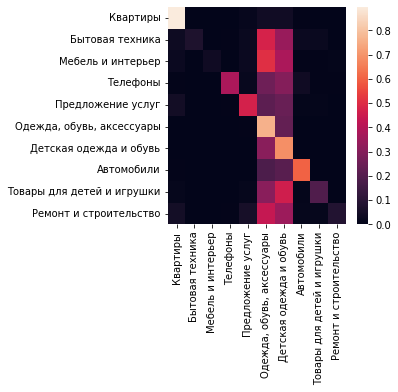

In [16]:
plt.figure(figsize=(4, 4))
sns.heatmap(errors_svd, xticklabels=metrics_svd.index.tolist()[:-1], 
            yticklabels=metrics_svd.index.tolist()[:-1])
plt.show()

## NMF

In [10]:
metrics_nmf, errors_nmf = eval_table(data['description_norm'], data['category_name'], pipeline_nmf_randomforest)

In [11]:
metrics_nmf

precision  precision_std  recall  recall_std  \
Квартиры                         0.88           0.03    0.95        0.03   
Бытовая техника                  1.00           0.00    0.03        0.01   
Мебель и интерьер                0.77           0.09    0.10        0.07   
Телефоны                         0.93           0.03    0.38        0.05   
Предложение услуг                0.67           0.07    0.48        0.05   
Одежда, обувь, аксессуары        0.46           0.04    0.81        0.05   
Детская одежда и обувь           0.62           0.07    0.71        0.05   
Автомобили                       0.89           0.03    0.76        0.05   
Товары для детей и игрушки       0.86           0.04    0.36        0.07   
Ремонт и строительство           0.79           0.21    0.04        0.02   
mean                             0.79           0.06    0.46        0.04   

                              f1  f1_std  
Квартиры                    0.91    0.02  
Бытовая техника             0.05    0.02  
Мебель и интерьер           0.17    0.10  
Телефоны                    0.54    0.04  
Предложение услуг           0.56    0.06  
Одежда, обувь, аксессуары   0.58    0.02  
Детская одежда и обувь      0.66    0.03  
Автомобили                  0.82    0.03  
Товары для детей и игрушки  0.50    0.07  
Ремонт и строительство      0.08    0.04  
mean                        0.49    0.04

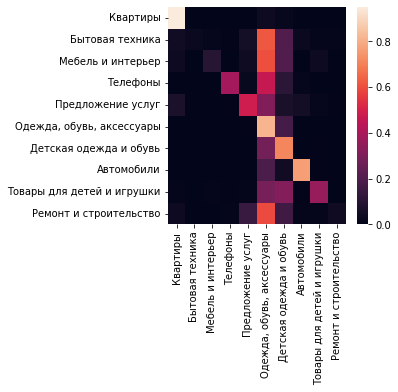

In [12]:
plt.figure(figsize=(4, 4))
sns.heatmap(errors_nmf, xticklabels=metrics_nmf.index.tolist()[:-1], 
            yticklabels=metrics_nmf.index.tolist()[:-1])
plt.show()

In [17]:
metrics_svd - metrics_nmf

precision  precision_std  recall  recall_std  \
Квартиры                         0.00          -0.01   -0.05        0.00   
Бытовая техника                 -0.21           0.25    0.04        0.04   
Мебель и интерьер                0.14           0.07   -0.06       -0.05   
Телефоны                         0.00           0.01    0.00        0.00   
Предложение услуг                0.07          -0.01   -0.01       -0.01   
Одежда, обувь, аксессуары        0.01          -0.02   -0.05       -0.03   
Детская одежда и обувь          -0.16          -0.05   -0.02       -0.02   
Автомобили                      -0.04           0.05   -0.16        0.00   
Товары для детей и игрушки      -0.01           0.01   -0.17       -0.01   
Ремонт и строительство          -0.03          -0.06    0.04        0.01   
mean                            -0.03           0.02   -0.04        0.00   

                              f1  f1_std  
Квартиры                   -0.02   -0.01  
Бытовая техника             0.08    0.06  
Мебель и интерьер          -0.10   -0.07  
Телефоны                    0.00    0.01  
Предложение услуг           0.01   -0.03  
Одежда, обувь, аксессуары   0.00   -0.01  
Детская одежда и обувь     -0.11   -0.01  
Автомобили                 -0.12    0.03  
Товары для детей и игрушки -0.19    0.02  
Ремонт и строительство      0.07    0.02  
mean                       -0.04    0.00

# ExtraTreesClassifier

In [18]:
pipeline_svd_extratrees = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1,2), min_df=5, max_df=0.4)),
    ('svd', TruncatedSVD(500)),
    ('clf', ExtraTreesClassifier(n_estimators=100, max_depth=10))
])

pipeline_nmf_extratrees = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), min_df=3, max_df=0.3)),
    ('tfidf', TfidfTransformer()),
    ('decomposition', NMF(100)),
    ('clf', RandomForestClassifier(n_estimators=200, max_depth=6))
])

In [19]:
def eval_table(X, y, pipeline, N=6):
    
    labels = list(set(y))
    fold_metrics = pd.DataFrame(index=labels)
    errors = np.zeros((len(labels), len(labels)))
    kfold = StratifiedKFold(n_splits=N, shuffle=True, )
    
    for i, (train_index, test_index) in enumerate(kfold.split(X, y)):
        pipeline.fit(X[train_index], y[train_index])
        preds = pipeline.predict(X[test_index])
        
        fold_metrics[f'precision_{i}'] = precision_score(y[test_index], preds, labels=labels, average=None)
        fold_metrics[f'recall_{i}'] = recall_score(y[test_index], preds, labels=labels, average=None)
        fold_metrics[f'f1_{i}'] = f1_score(y[test_index], preds, labels=labels, average=None)
        errors += confusion_matrix(y[test_index], preds, labels=labels, normalize='true')

    result = pd.DataFrame(index=labels)
    result['precision'] = fold_metrics[[f'precision_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['precision_std'] = fold_metrics[[f'precision_{i}' for i in range(N)]].std(axis=1).round(2)
    
    result['recall'] = fold_metrics[[f'recall_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['recall_std'] = fold_metrics[[f'recall_{i}' for i in range(N)]].std(axis=1).round(2)
    
    result['f1'] = fold_metrics[[f'f1_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['f1_std'] = fold_metrics[[f'f1_{i}' for i in range(N)]].std(axis=1).round(2)

    result.loc['mean'] = result.mean().round(2)
    
    errors /= N
    
    return result, errors

## SVD

In [20]:
metrics_svd, errors_svd = eval_table(data['description_norm'], data['category_name'], pipeline_svd_extratrees)


In [21]:
metrics_svd

precision  precision_std  recall  recall_std  \
Квартиры                         0.64           0.04    0.52        0.05   
Бытовая техника                  0.90           0.17    0.05        0.02   
Мебель и интерьер                0.78           0.40    0.02        0.01   
Телефоны                         1.00           0.00    0.10        0.04   
Предложение услуг                0.61           0.49    0.01        0.01   
Одежда, обувь, аксессуары        0.37           0.01    0.82        0.02   
Детская одежда и обувь           0.40           0.01    0.60        0.02   
Автомобили                       0.95           0.04    0.12        0.02   
Товары для детей и игрушки       0.86           0.12    0.06        0.02   
Ремонт и строительство           0.78           0.39    0.05        0.04   
mean                             0.73           0.17    0.23        0.02   

                              f1  f1_std  
Квартиры                    0.57    0.04  
Бытовая техника             0.09    0.04  
Мебель и интерьер           0.04    0.03  
Телефоны                    0.17    0.06  
Предложение услуг           0.03    0.03  
Одежда, обувь, аксессуары   0.51    0.01  
Детская одежда и обувь      0.48    0.01  
Автомобили                  0.21    0.03  
Товары для детей и игрушки  0.10    0.04  
Ремонт и строительство      0.10    0.07  
mean                        0.23    0.04

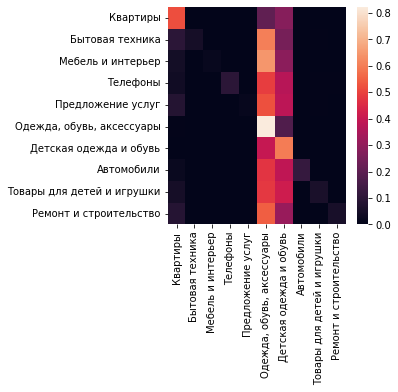

In [22]:
plt.figure(figsize=(4, 4))
sns.heatmap(errors_svd, xticklabels=metrics_svd.index.tolist()[:-1], 
            yticklabels=metrics_svd.index.tolist()[:-1])
plt.show()

## NMF 

In [23]:
metrics_nmf, errors_nmf = eval_table(data['description_norm'], data['category_name'], pipeline_nmf_randomforest)

In [24]:
metrics_nmf

precision  precision_std  recall  recall_std  \
Квартиры                         0.87           0.03    0.95        0.02   
Бытовая техника                  0.50           0.55    0.02        0.03   
Мебель и интерьер                0.86           0.10    0.15        0.10   
Телефоны                         0.94           0.06    0.25        0.14   
Предложение услуг                0.72           0.06    0.48        0.06   
Одежда, обувь, аксессуары        0.43           0.02    0.83        0.05   
Детская одежда и обувь           0.64           0.06    0.69        0.02   
Автомобили                       0.86           0.06    0.79        0.06   
Товары для детей и игрушки       0.86           0.06    0.33        0.04   
Ремонт и строительство           0.83           0.22    0.05        0.03   
mean                             0.75           0.12    0.45        0.06   

                              f1  f1_std  
Квартиры                    0.91    0.02  
Бытовая техника             0.04    0.06  
Мебель и интерьер           0.24    0.14  
Телефоны                    0.38    0.16  
Предложение услуг           0.57    0.03  
Одежда, обувь, аксессуары   0.57    0.02  
Детская одежда и обувь      0.66    0.03  
Автомобили                  0.82    0.04  
Товары для детей и игрушки  0.48    0.04  
Ремонт и строительство      0.09    0.05  
mean                        0.48    0.06

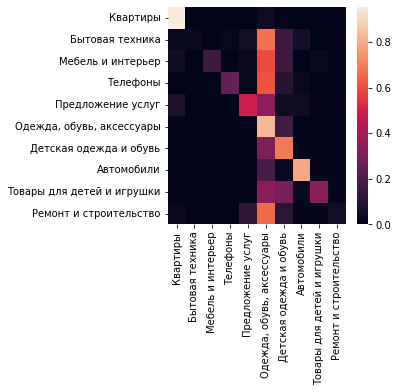

In [25]:
plt.figure(figsize=(4, 4))
sns.heatmap(errors_nmf, xticklabels=metrics_svd.index.tolist()[:-1], 
            yticklabels=metrics_nmf.index.tolist()[:-1])
plt.show()

In [26]:
metrics_svd - metrics_nmf

precision  precision_std  recall  recall_std  \
Квартиры                        -0.23           0.01   -0.43        0.03   
Бытовая техника                  0.40          -0.38    0.03       -0.01   
Мебель и интерьер               -0.08           0.30   -0.13       -0.09   
Телефоны                         0.06          -0.06   -0.15       -0.10   
Предложение услуг               -0.11           0.43   -0.47       -0.05   
Одежда, обувь, аксессуары       -0.06          -0.01   -0.01       -0.03   
Детская одежда и обувь          -0.24          -0.05   -0.09        0.00   
Автомобили                       0.09          -0.02   -0.67       -0.04   
Товары для детей и игрушки       0.00           0.06   -0.27       -0.02   
Ремонт и строительство          -0.05           0.17    0.00        0.01   
mean                            -0.02           0.05   -0.22       -0.04   

                              f1  f1_std  
Квартиры                   -0.34    0.02  
Бытовая техника             0.05   -0.02  
Мебель и интерьер          -0.20   -0.11  
Телефоны                   -0.21   -0.10  
Предложение услуг          -0.54    0.00  
Одежда, обувь, аксессуары  -0.06   -0.01  
Детская одежда и обувь     -0.18   -0.02  
Автомобили                 -0.61   -0.01  
Товары для детей и игрушки -0.38    0.00  
Ремонт и строительство      0.01    0.02  
mean                       -0.25   -0.02

# SGDClassifier

In [27]:
pipeline_svd_SGD = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1,2), min_df=5, max_df=0.4)),
    ('svd', TruncatedSVD(500)),
    ('clf', SGDClassifier())
])

pipeline_nmf_SGD = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), min_df=3, max_df=0.3)),
    ('tfidf', TfidfTransformer()),
    ('decomposition', NMF(100)),
    ('clf', RandomForestClassifier(n_estimators=200, max_depth=6))
])



In [28]:
def eval_table(X, y, pipeline, N=6):
    
    labels = list(set(y))
    fold_metrics = pd.DataFrame(index=labels)
    errors = np.zeros((len(labels), len(labels)))
    kfold = StratifiedKFold(n_splits=N, shuffle=True, )
    
    for i, (train_index, test_index) in enumerate(kfold.split(X, y)):
        pipeline.fit(X[train_index], y[train_index])
        preds = pipeline.predict(X[test_index])
        
        fold_metrics[f'precision_{i}'] = precision_score(y[test_index], preds, labels=labels, average=None)
        fold_metrics[f'recall_{i}'] = recall_score(y[test_index], preds, labels=labels, average=None)
        fold_metrics[f'f1_{i}'] = f1_score(y[test_index], preds, labels=labels, average=None)
        errors += confusion_matrix(y[test_index], preds, labels=labels, normalize='true')

    result = pd.DataFrame(index=labels)
    result['precision'] = fold_metrics[[f'precision_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['precision_std'] = fold_metrics[[f'precision_{i}' for i in range(N)]].std(axis=1).round(2)
    
    result['recall'] = fold_metrics[[f'recall_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['recall_std'] = fold_metrics[[f'recall_{i}' for i in range(N)]].std(axis=1).round(2)
    
    result['f1'] = fold_metrics[[f'f1_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['f1_std'] = fold_metrics[[f'f1_{i}' for i in range(N)]].std(axis=1).round(2)

    result.loc['mean'] = result.mean().round(2)
    
    errors /= N
    
    return result, errors

## SVD

In [29]:
metrics_svd, errors_svd = eval_table(data['description_norm'], data['category_name'], pipeline_svd_SGD)

In [30]:
metrics_svd

precision  precision_std  recall  recall_std  \
Квартиры                         0.97           0.02    0.96        0.02   
Бытовая техника                  0.62           0.07    0.49        0.06   
Мебель и интерьер                0.71           0.05    0.61        0.04   
Телефоны                         0.81           0.05    0.81        0.07   
Предложение услуг                0.78           0.06    0.75        0.04   
Одежда, обувь, аксессуары        0.68           0.03    0.81        0.03   
Детская одежда и обувь           0.76           0.03    0.74        0.03   
Автомобили                       0.87           0.02    0.89        0.03   
Товары для детей и игрушки       0.73           0.05    0.64        0.04   
Ремонт и строительство           0.61           0.04    0.47        0.06   
mean                             0.75           0.04    0.72        0.04   

                              f1  f1_std  
Квартиры                    0.96    0.01  
Бытовая техника             0.54    0.05  
Мебель и интерьер           0.66    0.03  
Телефоны                    0.81    0.04  
Предложение услуг           0.77    0.01  
Одежда, обувь, аксессуары   0.74    0.01  
Детская одежда и обувь      0.75    0.01  
Автомобили                  0.88    0.02  
Товары для детей и игрушки  0.68    0.03  
Ремонт и строительство      0.53    0.05  
mean                        0.73    0.03

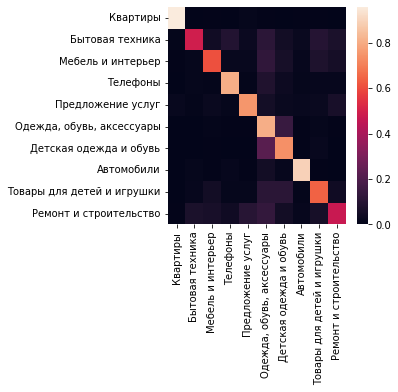

In [31]:
plt.figure(figsize=(4, 4))
sns.heatmap(errors_svd, xticklabels=metrics_svd.index.tolist()[:-1], 
            yticklabels=metrics_svd.index.tolist()[:-1])
plt.show()

## NMF

In [32]:
metrics_nmf, errors_nmf = eval_table(data['description_norm'], data['category_name'], pipeline_nmf_SGD)

In [33]:
metrics_nmf

precision  precision_std  recall  recall_std  \
Квартиры                         0.88           0.04    0.95        0.01   
Бытовая техника                  0.58           0.49    0.02        0.02   
Мебель и интерьер                0.81           0.12    0.14        0.06   
Телефоны                         0.89           0.08    0.33        0.09   
Предложение услуг                0.71           0.08    0.49        0.04   
Одежда, обувь, аксессуары        0.44           0.01    0.85        0.01   
Детская одежда и обувь           0.65           0.01    0.69        0.02   
Автомобили                       0.87           0.06    0.80        0.07   
Товары для детей и игрушки       0.85           0.06    0.32        0.04   
Ремонт и строительство           0.83           0.12    0.06        0.03   
mean                             0.75           0.11    0.46        0.04   

                              f1  f1_std  
Квартиры                    0.91    0.03  
Бытовая техника             0.04    0.04  
Мебель и интерьер           0.24    0.08  
Телефоны                    0.47    0.10  
Предложение услуг           0.57    0.04  
Одежда, обувь, аксессуары   0.58    0.01  
Детская одежда и обувь      0.67    0.02  
Автомобили                  0.83    0.04  
Товары для детей и игрушки  0.46    0.05  
Ремонт и строительство      0.12    0.06  
mean                        0.49    0.05

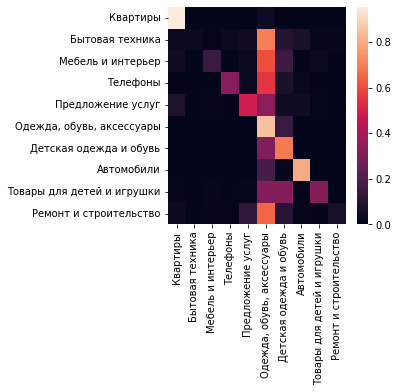

In [34]:
plt.figure(figsize=(4, 4))
sns.heatmap(errors_nmf, xticklabels=metrics_svd.index.tolist()[:-1], 
            yticklabels=metrics_nmf.index.tolist()[:-1])
plt.show()

In [35]:
metrics_svd - metrics_nmf

precision  precision_std  recall  recall_std  \
Квартиры                         0.09          -0.02    0.01        0.01   
Бытовая техника                  0.04          -0.42    0.47        0.04   
Мебель и интерьер               -0.10          -0.07    0.47       -0.02   
Телефоны                        -0.08          -0.03    0.48       -0.02   
Предложение услуг                0.07          -0.02    0.26        0.00   
Одежда, обувь, аксессуары        0.24           0.02   -0.04        0.02   
Детская одежда и обувь           0.11           0.02    0.05        0.01   
Автомобили                       0.00          -0.04    0.09       -0.04   
Товары для детей и игрушки      -0.12          -0.01    0.32        0.00   
Ремонт и строительство          -0.22          -0.08    0.41        0.03   
mean                             0.00          -0.07    0.26        0.00   

                              f1  f1_std  
Квартиры                    0.05   -0.02  
Бытовая техника             0.50    0.01  
Мебель и интерьер           0.42   -0.05  
Телефоны                    0.34   -0.06  
Предложение услуг           0.20   -0.03  
Одежда, обувь, аксессуары   0.16    0.00  
Детская одежда и обувь      0.08   -0.01  
Автомобили                  0.05   -0.02  
Товары для детей и игрушки  0.22   -0.02  
Ремонт и строительство      0.41   -0.01  
mean                        0.24   -0.02

## KNeighborsClassifier

In [36]:
pipeline_svd_kneighbours = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1,2), min_df=5, max_df=0.4)),
    ('svd', TruncatedSVD(500)),
    ('clf', KNeighborsClassifier())
])

pipeline_nmf_kneighbours = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), min_df=3, max_df=0.3)),
    ('tfidf', TfidfTransformer()),
    ('decomposition', NMF(100)),
    ('clf', RandomForestClassifier(n_estimators=200, max_depth=6))
])

In [37]:
def eval_table(X, y, pipeline, N=6):
    
    labels = list(set(y))
    fold_metrics = pd.DataFrame(index=labels)
    errors = np.zeros((len(labels), len(labels)))
    kfold = StratifiedKFold(n_splits=N, shuffle=True, )
    
    for i, (train_index, test_index) in enumerate(kfold.split(X, y)):
        pipeline.fit(X[train_index], y[train_index])
        preds = pipeline.predict(X[test_index])
        
        fold_metrics[f'precision_{i}'] = precision_score(y[test_index], preds, labels=labels, average=None)
        fold_metrics[f'recall_{i}'] = recall_score(y[test_index], preds, labels=labels, average=None)
        fold_metrics[f'f1_{i}'] = f1_score(y[test_index], preds, labels=labels, average=None)
        errors += confusion_matrix(y[test_index], preds, labels=labels, normalize='true')

    result = pd.DataFrame(index=labels)
    result['precision'] = fold_metrics[[f'precision_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['precision_std'] = fold_metrics[[f'precision_{i}' for i in range(N)]].std(axis=1).round(2)
    
    result['recall'] = fold_metrics[[f'recall_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['recall_std'] = fold_metrics[[f'recall_{i}' for i in range(N)]].std(axis=1).round(2)
    
    result['f1'] = fold_metrics[[f'f1_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['f1_std'] = fold_metrics[[f'f1_{i}' for i in range(N)]].std(axis=1).round(2)

    result.loc['mean'] = result.mean().round(2)
    
    errors /= N
    
    return result, errors

## SVD

In [38]:
metrics_svd, errors_svd = eval_table(data['description_norm'], data['category_name'], pipeline_svd_kneighbours)

In [39]:
metrics_svd

precision  precision_std  recall  recall_std  \
Квартиры                         0.94           0.03    0.72        0.04   
Бытовая техника                  0.26           0.06    0.26        0.06   
Мебель и интерьер                0.34           0.03    0.26        0.03   
Телефоны                         0.70           0.12    0.30        0.05   
Предложение услуг                0.60           0.03    0.56        0.03   
Одежда, обувь, аксессуары        0.47           0.02    0.59        0.01   
Детская одежда и обувь           0.48           0.02    0.62        0.04   
Автомобили                       0.57           0.06    0.59        0.03   
Товары для детей и игрушки       0.52           0.10    0.25        0.05   
Ремонт и строительство           0.28           0.05    0.17        0.02   
mean                             0.52           0.05    0.43        0.04   

                              f1  f1_std  
Квартиры                    0.82    0.03  
Бытовая техника             0.26    0.06  
Мебель и интерьер           0.29    0.03  
Телефоны                    0.42    0.06  
Предложение услуг           0.58    0.03  
Одежда, обувь, аксессуары   0.53    0.01  
Детская одежда и обувь      0.54    0.02  
Автомобили                  0.58    0.04  
Товары для детей и игрушки  0.33    0.06  
Ремонт и строительство      0.21    0.02  
mean                        0.46    0.04

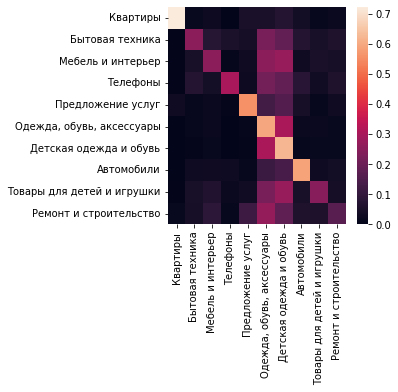

In [40]:
plt.figure(figsize=(4, 4))
sns.heatmap(errors_svd, xticklabels=metrics_svd.index.tolist()[:-1], 
            yticklabels=metrics_svd.index.tolist()[:-1])
plt.show()

## NMF

In [42]:
metrics_nmf, errors_nmf = eval_table(data['description_norm'], data['category_name'], pipeline_nmf_kneighbours)

In [43]:
metrics_nmf

precision  precision_std  recall  recall_std  \
Квартиры                         0.88           0.06    0.95        0.03   
Бытовая техника                  0.67           0.52    0.02        0.02   
Мебель и интерьер                0.75           0.09    0.14        0.05   
Телефоны                         0.97           0.03    0.24        0.13   
Предложение услуг                0.69           0.09    0.45        0.07   
Одежда, обувь, аксессуары        0.43           0.02    0.84        0.03   
Детская одежда и обувь           0.65           0.03    0.69        0.04   
Автомобили                       0.87           0.04    0.76        0.05   
Товары для детей и игрушки       0.85           0.05    0.35        0.02   
Ремонт и строительство           0.64           0.12    0.06        0.03   
mean                             0.74           0.11    0.45        0.05   

                              f1  f1_std  
Квартиры                    0.91    0.03  
Бытовая техника             0.04    0.04  
Мебель и интерьер           0.24    0.06  
Телефоны                    0.37    0.16  
Предложение услуг           0.54    0.06  
Одежда, обувь, аксессуары   0.57    0.02  
Детская одежда и обувь      0.67    0.02  
Автомобили                  0.81    0.02  
Товары для детей и игрушки  0.49    0.02  
Ремонт и строительство      0.11    0.05  
mean                        0.48    0.05

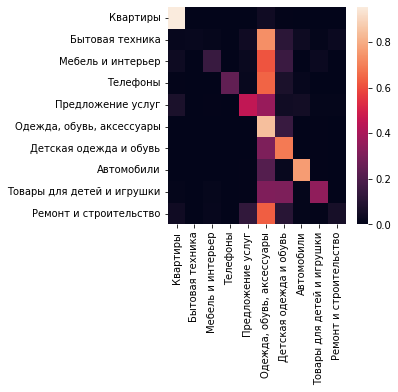

In [44]:
plt.figure(figsize=(4, 4))
sns.heatmap(errors_nmf, xticklabels=metrics_svd.index.tolist()[:-1], 
            yticklabels=metrics_nmf.index.tolist()[:-1])
plt.show()

In [45]:
metrics_svd - metrics_nmf

precision  precision_std  recall  recall_std  \
Квартиры                         0.06          -0.03   -0.23        0.01   
Бытовая техника                 -0.41          -0.46    0.24        0.04   
Мебель и интерьер               -0.41          -0.06    0.12       -0.02   
Телефоны                        -0.27           0.09    0.06       -0.08   
Предложение услуг               -0.09          -0.06    0.11       -0.04   
Одежда, обувь, аксессуары        0.04           0.00   -0.25       -0.02   
Детская одежда и обувь          -0.17          -0.01   -0.07        0.00   
Автомобили                      -0.30           0.02   -0.17       -0.02   
Товары для детей и игрушки      -0.33           0.05   -0.10        0.03   
Ремонт и строительство          -0.36          -0.07    0.11       -0.01   
mean                            -0.22          -0.06   -0.02       -0.01   

                              f1  f1_std  
Квартиры                   -0.09    0.00  
Бытовая техника             0.22    0.02  
Мебель и интерьер           0.05   -0.03  
Телефоны                    0.05   -0.10  
Предложение услуг           0.04   -0.03  
Одежда, обувь, аксессуары  -0.04   -0.01  
Детская одежда и обувь     -0.13    0.00  
Автомобили                 -0.23    0.02  
Товары для детей и игрушки -0.16    0.04  
Ремонт и строительство      0.10   -0.03  
mean                       -0.02   -0.01

# Выводы:

По метрике precision лучшее сочетание - RandomForest + NMF. По метрике recall - SGDClassifyer + SVD. Оптимально использовать SGDClassifyer+ SVD, поскольку его precision не сильно отличается от максимального, но recall значительно выше, чем в других сочетаниях.
В среднем, любые сочетания классификатора с NMF лучше, чем аналогичные с SVD (SGDClassifyer - исключение из этой тенденции).

### Задание № 2 (6 баллов)

В Gensim тоже можно добавить нграммы и tfidf. Постройте 1 модель без них (как в семинаре) и еще 3 модели (1 с нграммами, 1 с tfidf и 1 с нграммами и с tfidf). Сранивте качество с помощью метрик (перплексия, когерентность) и на глаз. Определите лучшую модель. Для каждой модели выберите 1 самую красивую на ваш взгляд тему.

Используйте данные википедии из семинара. Можете взять поменьше данных, если все обучается долго.

Важное требование - получившиеся модели не должны быть совсем плохими. Если хороших тем не получается, попробуйте настроить гиперпараметры, отфильтровать словарь по-другому. 

# 1. Модель без N-грамм и tfidf

In [308]:
texts = open('wiki_data.txt', encoding="utf8").read().splitlines()[:3000]
texts = ([normalize(text) for text in texts])

In [309]:
dictinary = gensim.corpora.Dictionary((text.split() for text in texts))

In [310]:
dictinary.filter_extremes(no_above=0.1, no_below=10)
dictinary.compactify()

In [311]:
print(dictinary)

Dictionary<5365 unique tokens: ['1,2', '1,5', '12', '14', '16']...>


In [312]:
corpus = [dictinary.doc2bow(text.split()) for text in texts]

In [313]:
lda = gensim.models.LdaModel(corpus, 100, id2word=dictinary, passes=20)

In [314]:
lda.print_topics()

[(23,
  '0.056*"лига" + 0.054*"команда" + 0.045*"сезон" + 0.042*"дивизион" + 0.031*"графство" + 0.027*"эксперимент" + 0.022*"иран" + 0.020*"формулы-1" + 0.018*"ум" + 0.017*"i"'),
 (9,
  '0.054*"лагерь" + 0.053*"вино" + 0.034*"серия" + 0.033*"заключить" + 0.031*"пол" + 0.026*"брат" + 0.021*"произведение" + 0.019*"сексуальный" + 0.015*"заниматься" + 0.013*"концентрационный"'),
 (84,
  '0.067*"список" + 0.056*"объект" + 0.038*"пара" + 0.031*"наследие" + 0.025*"всемирный" + 0.021*"археология" + 0.021*"материал" + 0.020*"цилиндр" + 0.020*"баня" + 0.019*"устройство"'),
 (44,
  '0.021*"образ" + 0.021*"нижний" + 0.021*"свет" + 0.019*"переход" + 0.019*"энергия" + 0.016*"s" + 0.016*"изображение" + 0.015*"помощь" + 0.015*"7" + 0.013*"ткань"'),
 (29,
  '0.077*"испытание" + 0.063*"бомба" + 0.062*"взрыв" + 0.049*"час" + 0.046*"минута" + 0.035*"12" + 0.032*"финляндия" + 0.030*"31" + 0.022*"финский" + 0.021*"км"'),
 (39,
  '0.031*"здание" + 0.029*"проект" + 0.025*"строительство" + 0.016*"музей" + 0.01

In [315]:
np.exp2(-lda.log_perplexity(corpus[:1000]))

373.31540531212926

In [316]:
topics = []
for topic_id, topic in lda.show_topics(num_topics=100, formatted=False):
    topic = [word for word, _ in topic]
    topics.append(topic)

In [317]:
coherence_model_lda = gensim.models.CoherenceModel(topics=topics, 
                                                   texts=[text.split() for text in texts], 
                                                   dictionary=dictinary, coherence='c_v')

In [318]:
coherence_model_lda.get_coherence()

0.5220601360920972

In [319]:
pyLDAvis.enable_notebook()

In [320]:
pyLDAvis.gensim_models.prepare(lda, corpus, dictinary)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
22     0.210198 -0.116321       1        1  4.677072
78     0.183126 -0.120264       2        1  4.484390
85     0.231900 -0.040246       3        1  4.321863
72    -0.109472 -0.207624       4        1  4.040340
95    -0.093067 -0.165367       5        1  3.918703
...         ...       ...     ...      ...       ...
40     0.008628  0.097179      96        1  0.207593
45    -0.057479  0.110235      97        1  0.199751
18    -0.009177  0.112663      98        1  0.196132
96    -0.032238  0.111357      99        1  0.123064
73    -0.008763  0.133110     100        1  0.107960

[100 rows x 5 columns], topic_info=               Term        Freq       Total  Category  logprob  loglift
640            уезд  651.000000  651.000000   Default  30.0000  30.0000
100           фильм  568.000000  568.000000   Default  29.0000  29.0000
1231          совет  548.000000  548.000000   Default  28.0000  28.0000
2814         летний  505.000000  505.000000   Default  27.0000  27.0000
109          остров  482.000000  482.000000   Default  26.0000  26.0000
...             ...         ...         ...       ...      ...      ...
1175         издать    2.085726   75.437782  Topic100  -5.1686   3.2430
2075  отечественный    5.367645  201.628252  Topic100  -4.2234   3.2051
1416              б    3.929677  206.965986  Topic100  -4.5352   2.8672
3861   северо-запад    1.399374   57.583520  Topic100  -5.5677   3.1140
3740      исполнить    1.558393   77.824283  Topic100  -5.4601   2.9204

[4851 rows x 6 columns], token_table=      Topic      Freq Term
term                      
644       3  0.078178    0
644       5  0.531610    0
644      62  0.375254    0
5023     32  0.671886  0,5
5023     84  0.074654  0,5
...     ...       ...  ...
487      74  0.021777    №
487      75  0.041135    №
487      76  0.009679    №
487      78  0.007259    №
487      80  0.014518    №

[20958 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[23, 79, 86, 73, 96, 90, 14, 88, 40, 7, 34, 51, 78, 55, 69, 89, 18, 16, 43, 65, 66, 76, 60, 100, 54, 17, 58, 28, 33, 77, 63, 72, 53, 94, 49, 50, 67, 93, 57, 36, 11, 91, 95, 64, 13, 5, 9, 32, 27, 92, 26, 39, 8, 75, 80, 2, 25, 59, 99, 45, 70, 1, 87, 81, 38, 24, 71, 10, 44, 52, 3, 12, 29, 84, 48, 31, 85, 22, 35, 68, 98, 47, 62, 83, 20, 4, 42, 61, 82, 6, 15, 30, 37, 56, 21, 41, 46, 19, 97, 74])

# 2. Модель с N-граммами

In [321]:
texts = open('wiki_data.txt', encoding="utf8").read().splitlines()[:3000]
texts = ([normalize(text) for text in texts])

In [322]:
texts = [text.split() for text in texts]
ph = gensim.models.Phrases(texts, scoring='npmi', threshold=0.4)
p = gensim.models.phrases.Phraser(ph)
ngrammed_texts = p[texts] 

In [323]:
[text for text in ngrammed_texts[:3]]

[['новостройка',
  'нижегородский_область',
  'новостро́йка',
  '—',
  'сельский',
  'посёлок',
  'в',
  'дивеевский_район',
  'нижегородский_область',
  'входить',
  'в',
  'состав_сатисский',
  'сельсовет',
  'посёлок',
  'расположить',
  'в',
  '12,5',
  'км',
  'к_юг',
  'от',
  'село_дивеево',
  'и',
  '1',
  'км',
  'к_запад',
  'от',
  'город',
  'саров',
  'на',
  'право_берег',
  'река',
  'вичкинза',
  'правый_приток',
  'река',
  'сатис',
  'окружить',
  'смешанный_лес',
  'соединить',
  'асфальтовый',
  'дорога',
  'с',
  'посёлок',
  'цыгановка',
  '1,5_км',
  'и',
  'грунтовый',
  'просёлочный',
  'дорога',
  'с',
  'посёлок_сатис',
  '3,5_км',
  'название',
  'новостройка',
  'являться',
  'сугубо',
  'официальный',
  'местный',
  'население',
  'использовать',
  'исключительно',
  'альтернативный',
  'название',
  '—',
  'хитрый',
  'употребляться_языковой',
  'оборот',
  '«',
  '…',
  'на',
  'хитрый',
  '»',
  'ранее',
  'использовать',
  'название',
  '—',
  'песчаны

In [324]:
dictinary = gensim.corpora.Dictionary((text for text in ngrammed_texts))

In [325]:
dictinary.filter_extremes(no_above=0.1, no_below=10)
dictinary.compactify()

In [326]:
print(dictinary)

Dictionary<5969 unique tokens: ['1,2', '1,5_км', '12', '14', '16']...>


In [327]:
corpus = [dictinary.doc2bow(text) for text in texts]

In [328]:
lda = gensim.models.LdaModel(corpus, 100, id2word=dictinary, passes=25)

In [329]:
lda.print_topics()

[(31,
  '0.035*"i" + 0.026*"ii" + 0.017*"граф" + 0.014*"тот" + 0.013*"сын" + 0.012*"iii" + 0.012*"войско" + 0.011*"император" + 0.011*"смерть" + 0.011*"отряд"'),
 (63,
  '0.085*"компания" + 0.056*"билет" + 0.044*"7" + 0.033*"рубль" + 0.028*"община" + 0.024*"сторона" + 0.021*"бумага" + 0.018*"500" + 0.017*"ноябрь" + 0.017*"s"'),
 (33,
  '0.089*"корабль" + 0.068*"флот" + 0.047*"морской" + 0.043*"лодка" + 0.027*"боевой" + 0.026*"сила" + 0.023*"море" + 0.022*"ракетный" + 0.019*"военно-морской" + 0.019*"орудие"'),
 (17,
  '0.079*"система" + 0.022*"схема" + 0.018*"ядро" + 0.017*"состояние" + 0.016*"эксперимент" + 0.016*"реакция" + 0.013*"давление" + 0.013*"метод" + 0.012*"связь" + 0.012*"способ"'),
 (4,
  '0.048*"роман" + 0.042*"серия" + 0.034*"брат" + 0.030*"марка" + 0.027*"произведение" + 0.025*"пол" + 0.023*"книга" + 0.018*"белый" + 0.018*"текст" + 0.018*"полиция"'),
 (20,
  '0.082*"брак" + 0.027*"россия" + 0.027*"пара" + 0.024*"семейный" + 0.023*"женщина" + 0.022*"супруг" + 0.021*"россий

In [330]:
np.exp2(-lda.log_perplexity(corpus[:1000]))

323.44552344976785

In [331]:
topics = []
for topic_id, topic in lda.show_topics(num_topics=100, formatted=False):
    topic = [word for word, _ in topic]
    topics.append(topic)

In [332]:
coherence_model_lda = gensim.models.CoherenceModel(topics=topics, 
                                                   texts=[text for text in ngrammed_texts], 
                                                   dictionary=dictinary, coherence='c_v')

In [333]:
coherence_model_lda.get_coherence()

0.4863300845434784

In [334]:
pyLDAvis.enable_notebook()

In [335]:
pyLDAvis.gensim_models.prepare(lda, corpus, dictinary)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
89    -0.230852  0.079379       1        1  4.603179
77    -0.177735  0.036793       2        1  4.405827
39    -0.051263 -0.180339       3        1  4.125981
29    -0.040637 -0.229352       4        1  3.652086
65    -0.153005 -0.107414       5        1  3.071793
...         ...       ...     ...      ...       ...
68     0.086324  0.107130      96        1  0.097246
52     0.120875  0.099800      97        1  0.076907
23     0.135605  0.099367      98        1  0.076597
51     0.130672  0.109339      99        1  0.056129
3      0.118879  0.110433     100        1  0.034638

[100 rows x 5 columns], topic_info=             Term         Freq        Total  Category  logprob  loglift
214          игра  1407.000000  1407.000000   Default  30.0000  30.0000
1226         село  1227.000000  1227.000000   Default  29.0000  29.0000
5403  житомирский   908.000000   908.000000   Default  28.0000  28.0000
2149  олимпийский   967.000000   967.000000   Default  27.0000  27.0000
5364          код   732.000000   732.000000   Default  26.0000  26.0000
...           ...          ...          ...       ...      ...      ...
2048   московский     1.056849   232.791110  Topic100  -4.7662   2.5731
2256        стиль     0.617702   136.212971  Topic100  -5.3032   2.5720
3466      близкий     0.763932   182.063188  Topic100  -5.0907   2.4944
104       русский     1.330284   463.700079  Topic100  -4.5361   2.1141
251      наиболее     0.682059   232.877656  Topic100  -5.2041   2.1348

[4914 rows x 6 columns], token_table=      Topic      Freq Term
term                      
633       5  0.603979    0
633      39  0.048971    0
633      90  0.342799    0
5541     20  0.061832  0,5
5541     36  0.865648  0,5
...     ...       ...  ...
472      60  0.007300    №
472      67  0.004867    №
472      76  0.007300    №
472      77  0.007300    №
472      80  0.009734    №

[20805 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[90, 78, 40, 30, 66, 50, 16, 81, 39, 25, 42, 56, 87, 71, 57, 33, 77, 61, 63, 55, 86, 3, 100, 26, 32, 94, 28, 73, 93, 58, 62, 95, 88, 89, 54, 18, 2, 22, 46, 83, 6, 37, 21, 96, 13, 19, 99, 8, 35, 74, 76, 97, 14, 60, 65, 85, 38, 36, 11, 5, 12, 64, 15, 9, 20, 72, 34, 7, 10, 79, 47, 48, 82, 84, 45, 98, 44, 23, 80, 43, 49, 70, 75, 67, 27, 68, 31, 1, 41, 29, 92, 51, 91, 59, 17, 69, 53, 24, 52, 4])

# 3. Модель с tfidf

In [46]:
texts = open('wiki_data.txt', encoding="utf8").read().splitlines()[:3000]
texts = ([normalize(text) for text in texts])

In [47]:
dictinary = gensim.corpora.Dictionary((text.split() for text in texts))

In [48]:
dictinary.filter_extremes(no_above=0.1, no_below=10)
dictinary.compactify()

In [49]:
print(dictinary)

Dictionary<5365 unique tokens: ['1,2', '1,5', '12', '14', '16']...>


In [50]:
corpus = [dictinary.doc2bow(text.split()) for text in texts]

In [51]:
tfidf = gensim.models.TfidfModel(corpus, id2word=dictinary)
corpus = tfidf[corpus]

In [93]:
lda = gensim.models.LdaModel(corpus, 150, id2word=dictinary, passes=15)

In [94]:
lda.print_topics()

[(39,
  '0.040*"нил" + 0.000*"of" + 0.000*"нью-йорк" + 0.000*"the" + 0.000*"университет" + 0.000*"2006" + 0.000*"вести" + 0.000*"начать" + 0.000*"вселенная" + 0.000*"степень"'),
 (149,
  '0.058*"2008" + 0.034*"функция" + 0.033*"устройство" + 0.027*"охранять" + 0.024*"сербский" + 0.024*"применяться" + 0.023*"элемент" + 0.023*"конструкция" + 0.021*"способ" + 0.020*"пространство"'),
 (19,
  '0.073*"община" + 0.054*"крым" + 0.040*"екатерина" + 0.038*"михаилович" + 0.035*"крымский" + 0.027*"севастополь" + 0.005*"госпиталь" + 0.004*"воспоминание" + 0.003*"вы" + 0.001*"медицинский"'),
 (54,
  '0.000*"самолёт" + 0.000*"песня" + 0.000*"истребитель" + 0.000*"пилот" + 0.000*"аэродром" + 0.000*"альбом" + 0.000*"the" + 0.000*"лётчик" + 0.000*"полёт" + 0.000*"упасть"'),
 (69,
  '0.101*"река" + 0.080*"пункт" + 0.045*"деревня" + 0.042*"округ" + 0.037*"дорога" + 0.028*"образовать" + 0.027*"высота" + 0.022*"аэропорт" + 0.021*"северный" + 0.020*"запад"'),
 (43,
  '0.090*"авианосец" + 0.030*"гимн" + 0.028

In [95]:
np.exp2(-lda.log_perplexity(corpus[:1000]))

7.729388248625578e+26

In [96]:
topics = []
for topic_id, topic in lda.show_topics(num_topics=100, formatted=False):
    topic = [word for word, _ in topic]
    topics.append(topic)

In [97]:
coherence_model_lda = gensim.models.CoherenceModel(topics=topics, 
                                                   texts=[text.split() for text in texts], 
                                                   dictionary=dictinary, coherence='c_v')

In [98]:
coherence_model_lda.get_coherence()

0.648810157614895

Попытка починить неработающий с tf-idf LDAvis (с этим кодом получается через раз, без него совсем не работает):

In [99]:
import json
import os
import re
import shutil
import warnings
import numpy as np
import pyLDAvis.urls


class NumPyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.int64) or isinstance(obj, np.int32):
            return int(obj)
        if isinstance(obj, np.float64) or isinstance(obj, np.float32):
            return float(obj)
        if np.iscomplexobj(obj):
            return abs(obj)
        return json.JSONEncoder.default(self, obj)

In [100]:
pyLDAvis.enable_notebook()

In [101]:
pyLDAvis.gensim_models.prepare(lda, corpus, dictinary)

TypeError: Object of type complex is not JSON serializable

PreparedData(topic_coordinates=                        x                   y  topics  cluster       Freq
topic                                                                    
113    0.296285+0.000000j -0.351069+0.000000j       1        1  11.656983
100    0.327267+0.000000j  0.014916+0.000000j       2        1  10.412829
0      0.293452+0.000000j  0.134643+0.000000j       3        1   4.132478
74     0.247744+0.000000j -0.174769+0.000000j       4        1   3.847822
37     0.260332+0.000000j  0.044855+0.000000j       5        1   3.267868
...                   ...                 ...     ...      ...        ...
67    -0.026475+0.000000j -0.000417+0.000000j     146        1   0.180036
64    -0.026475+0.000000j -0.000417+0.000000j     147        1   0.180036
62    -0.026475+0.000000j -0.000417+0.000000j     148        1   0.180036
60    -0.026475+0.000000j -0.000417+0.000000j     149        1   0.180036
22    -0.026475+0.000000j -0.000417+0.000000j     150        1   0.180036

[150 r

Значительно лучше метрики по сравнению с предыдущими моделями, но есть повторения тем. Удалось визуализировать LDAvis только один раз, дальше снова показывает ошибку.

# 4. Модель с N-граммами и tfidf

In [85]:
texts = open('wiki_data.txt', encoding="utf8").read().splitlines()[:3000]
texts = ([normalize(text) for text in texts])

In [87]:
texts = [text.split() for text in texts]
ph = gensim.models.Phrases(texts, scoring='npmi', threshold=0.4)
p = gensim.models.phrases.Phraser(ph)
ngrammed_texts = p[texts] 

In [89]:
dictinary = gensim.corpora.Dictionary((text) for text in ngrammed_texts)

In [91]:
dictinary.filter_extremes(no_above=0.1, no_below=10)
dictinary.compactify()

In [93]:
print(dictinary)

Dictionary<5969 unique tokens: ['1,2', '1,5_км', '12', '14', '16']...>


In [95]:
corpus = [dictinary.doc2bow(text) for text in ngrammed_texts]

In [97]:
tfidf = gensim.models.TfidfModel(corpus, id2word=dictinary)
corpus = tfidf[corpus]

In [99]:
lda = gensim.models.LdaModel(corpus, 150, id2word=dictinary, passes=10)

In [101]:
lda.print_topics()

[(139,
  '0.296*"ул" + 0.135*"улица" + 0.024*"дворец" + 0.023*"киев" + 0.022*"проект" + 0.021*"здание" + 0.019*"киевский" + 0.019*"архитектор" + 0.018*"19" + 0.018*"городской_округ"'),
 (63,
  '0.283*"игра" + 0.030*"разработчик" + 0.028*"игровой" + 0.027*"пользователь" + 0.026*"компьютерный_игра" + 0.025*"игрок" + 0.022*"особенность" + 0.013*"выпускать" + 0.011*"распространяться" + 0.007*"представлять_себя"'),
 (2,
  '0.009*"бомбардировщик" + 0.000*"аэродром" + 0.000*"р" + 0.000*"самолёт" + 0.000*"истребитель" + 0.000*"уничтожить" + 0.000*"бой" + 0.000*"1942_год" + 0.000*"воздух" + 0.000*"операция"'),
 (34,
  '0.082*"фильм" + 0.046*"принц" + 0.034*"режиссёр" + 0.033*"комедия" + 0.032*"есть" + 0.026*"уилсон" + 0.024*"кинофестиваль" + 0.023*"лондонский" + 0.019*"охотник" + 0.013*"династия"'),
 (76,
  '0.000*"правитель" + 0.000*"отмечаться" + 0.000*"числиться" + 0.000*"училище" + 0.000*"температура" + 0.000*"содержаться" + 0.000*"семя" + 0.000*"резко" + 0.000*"присоединить_к" + 0.000*"пре

In [103]:
np.exp2(-lda.log_perplexity(corpus[:1000]))

2.8843410827973366e+30

In [104]:
topics = []
for topic_id, topic in lda.show_topics(num_topics=100, formatted=False):
    topic = [word for word, _ in topic]
    topics.append(topic)

In [105]:
coherence_model_lda = gensim.models.CoherenceModel(topics=topics, 
                                                   texts=[text for text in ngrammed_texts], 
                                                   dictionary=dictinary, coherence='c_v')

In [106]:
coherence_model_lda.get_coherence()

0.4567654904632359

In [107]:
import json
import os
import re
import shutil
import warnings
import numpy as np
import pyLDAvis.urls


class NumPyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.int64) or isinstance(obj, np.int32):
            return int(obj)
        if isinstance(obj, np.float64) or isinstance(obj, np.float32):
            return float(obj)
        if np.iscomplexobj(obj):
            return abs(obj)
        return json.JSONEncoder.default(self, obj)

In [108]:
pyLDAvis.enable_notebook()

In [109]:
pyLDAvis.gensim_models.prepare(lda, corpus, dictinary)

TypeError: Object of type complex is not JSON serializable

PreparedData(topic_coordinates=                        x                   y  topics  cluster       Freq
topic                                                                    
26    -0.307587+0.000000j  0.192600+0.000000j       1        1  10.154807
96    -0.315120+0.000000j  0.028858+0.000000j       2        1   5.729517
24    -0.286607+0.000000j -0.285255+0.000000j       3        1   5.512307
100   -0.303823+0.000000j -0.094971+0.000000j       4        1   5.298260
11    -0.251313+0.000000j  0.101062+0.000000j       5        1   3.946753
...                   ...                 ...     ...      ...        ...
76     0.022858+0.000000j  0.000366+0.000000j     146        1   0.200520
70     0.022858+0.000000j  0.000366+0.000000j     147        1   0.200520
64     0.022858+0.000000j  0.000366+0.000000j     148        1   0.200520
62     0.022858+0.000000j  0.000366+0.000000j     149        1   0.200520
149    0.022857+0.000000j  0.000366+0.000000j     150        1   0.200520

[150 r

Интересно, что если в этой модели поставить 100 тем и pass=15, то полученные темы будут различаться, но перплексия достигнет гигантских значений (78963024480868.42), а когерентность будет низкой (около 0.38). Лучшие метрики получаются, когда модель выдаёт одинаковые частотные слова во всех (или почти всех) группах.

# Выводы

Метрики у моделей с tf-idf получаются наилучшими, когда частотные слова очень многих групп одинаковы. Я постаралась достичь оптимума между лучшей метрикой и интерпретируемостью результатов.

Перплексия ниже всего у модели с сочетанием tf-idf и нграмм (2.88), её когерентность составляет 0.46. Я считаю, что данная модель оптимальна. Вторая по качеству модель с tf-idf: её перплексия близка к наилучшей (7.7), и когерентность достигает самых высоких значений (0.65).